In [6]:
!pip install --upgrade gym==0.25.2

In [7]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [182]:
!pip install swig
!pip install gym[box2d]==0.25.2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Using cached swig-4.1.1-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.8 MB)
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached pygame-2.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2373080 sha256=7062ee16f86e463988feb8be2d59bbd9a75da6e54618ccfb0076954ce147c331
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.0
    Uninstalling pygame-2.5.0:
      Successfully uninstalled pygame-2.5.0


In [172]:
!apt-get install x11-utils > /dev/null 2>&1
!pip install pyglet > /dev/null 2>&1
!apt-get install -y xvfb python3-opengl

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-opengl is already the newest version (3.1.5+dfsg-1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 57.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
ERROR: Could not build wheels for box2d-py, which is required to install pyproject.toml-ba

In [173]:
!pip install pyvirtualdisplay > /dev/null 2>&1

In [8]:
from IPython import display as ipythondisplay

In [9]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

KeyboardInterrupt: ignored

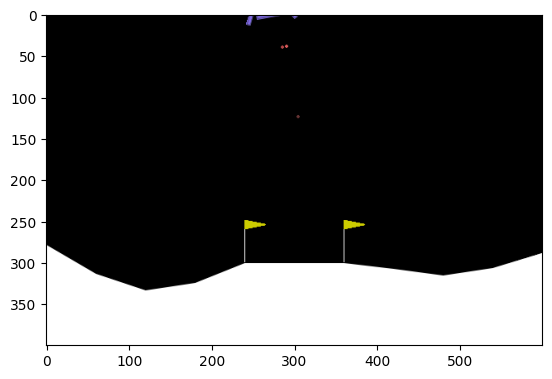

In [55]:
env = gym.make("LunarLander-v2")
env.reset()

prev_screen = env.render(mode="rgb_array")
plt.imshow(prev_screen)

num_actions = 200
for i in range(num_actions):
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    screen = env.render(mode="rgb_array")
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    if done:
        break

ipythondisplay.clear_output(wait=True)
env.close()

In [10]:
class ActorNet(nn.Module):
  def __init__(self, state_size, action_size, hidden_size):
    super(ActorNet, self).__init__()
    self.dense_layer1 = nn.Linear(state_size, hidden_size)
    self.dense_layer2 = nn.Linear(hidden_size, hidden_size)
    self.output = nn.Linear(hidden_size, action_size)

  def forward(self, X):
    X = torch.clamp(X, -1.1, 1.1)
    X = F.relu(self.dense_layer1(X))
    X = F.relu(self.dense_layer2(X))
    return F.softmax(self.output(X), dim=-1)

class ValueFunctionNet(nn.Module):
  def __init__(self, state_size, hidden_size):
    super(ValueFunctionNet, self).__init__()
    self.dense_layer1 = nn.Linear(state_size, hidden_size)
    self.dense_layer2 = nn.Linear(hidden_size, hidden_size)
    self.output = nn.Linear(hidden_size, 1)

  def forward(self, X):
    X = torch.clamp(X, -1.1, 1.1)
    X = F.relu(self.dense_layer1(X))
    X = F.relu(self.dense_layer2(X))
    return self.output(X)

In [11]:
class PGAgent:
  def __init__(self, state_size, action_size, hidden_size, actor_lr, value_lr, discount):
    self.action_size = action_size
    self.actor_net = ActorNet(state_size, action_size, hidden_size).to(device)
    self.vf_net = ValueFunctionNet(state_size, hidden_size).to(device)
    self.actor_optimizer = optim.AdamW(self.actor_net.parameters(), lr=actor_lr)
    self.vf_optimizer = optim.AdamW(self.vf_net.parameters(), lr=value_lr)
    self.discount = discount

  def select_action(self, state):
    with torch.no_grad():
      input_state = torch.FloatTensor(state).to(device)
      action_probs = self.actor_net(input_state)
      action_probs = action_probs.detach().cpu().numpy()
      action = np.random.choice(np.arange(self.action_size), p=action_probs)
    return action

  def train(self, state_list, action_list, reward_list):
    trajectory_len = len(reward_list)
    return_array = np.zeros((trajectory_len,))
    return_ = 0
    for i in range(trajectory_len - 1, -1, -1):
      return_ = reward_list[i] + self.discount * return_
      return_array[i] = return_

    state_tensor = torch.FloatTensor(np.array(state_list), device=device)
    action_tensor = torch.LongTensor(np.array(action_list), device=device)
    return_tensor = torch.FloatTensor(np.array(return_array), device=device)

    vf_tensor = self.vf_net(state_tensor).to(device)
    with torch.no_grad():
      advantage_tensor = return_tensor.reshape(-1, 1) - vf_tensor

    selected_action_prob = self.actor_net(state_tensor)
    selected_action_prob = torch.max(selected_action_prob, dim=1).values.reshape(-1, 1).gather(0, action_tensor.reshape(-1, 1))
    actor_loss = torch.mean(-torch.log(torch.t(selected_action_prob)) * advantage_tensor)
    self.actor_optimizer.zero_grad()
    actor_loss.backward()
    self.actor_optimizer.step()

    loss_fn = nn.MSELoss()
    vf_loss = loss_fn(vf_tensor, return_tensor.reshape(-1, 1))
    self.vf_optimizer.zero_grad()
    vf_loss.backward()
    self.vf_optimizer.step()

    return actor_loss.detach().cpu().numpy(), vf_loss.detach().cpu().numpy()

In [56]:
env = gym.make("LunarLander-v2")

In [57]:
# set seed
SEED = 31
env.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

In [58]:
# config
EPISODES = 5000 # run agent for this many episodes
HIDDEN_SIZE = 256 # number of units in NN hidden layers
ACTOR_LR = 0.002 # learning rate for actor
VALUE_FUNCTION_LR = 0.002 # learning rate for value function
DISCOUNT_RATE = 0.99 # discount factor gamma value
REWARD_SCALE = 0.01 #scale reward by this amount

In [59]:
action_size = env.action_space.n
state_size = env.observation_space.shape[0]
agent = PGAgent(state_size, action_size, HIDDEN_SIZE, ACTOR_LR, VALUE_FUNCTION_LR, DISCOUNT_RATE)

In [60]:
stats_reward_list = []
print_stats_every = 1
total_reward = 0
timesteps = 0
episode_length = 0
stats_actor_loss, stats_vf_loss = 0., 0.

for episode in range(EPISODES):
  state = env.reset()
  state_list, action_list, reward_list = [], [], []

  if len(stats_reward_list) > print_stats_every and np.mean(stats_reward_list[-print_stats_every:], axis=0)[1] > 500:
    print("Stopping at episode {} with average rewards of {} in last {} episodes".
            format(episode, np.mean(stats_reward_list[-print_stats_every:],axis=0)[1], print_stats_every))
    break

  while True:
    timesteps += 1
    action = agent.select_action(state)
    next_state, reward, done, _ = env.step(action)
    total_reward += reward
    episode_length += 1

    state_list.append(state)
    action_list.append(action)
    reward_list.append(reward * REWARD_SCALE)

    if done:
      actor_loss, vf_loss = agent.train(state_list, action_list, reward_list)
      stats_reward_list.append((episode, total_reward, episode_length))
      stats_actor_loss += actor_loss
      stats_vf_loss += vf_loss
      total_reward = 0
      episode_length = 0
      if episode % print_stats_every == 0:
        print('Episode: {}'.format(episode),
              'Timestep: {}'.format(timesteps),
              'Total reward: {:.1f}'.format(np.mean(stats_reward_list[-print_stats_every:],axis=0)[1]),
              'Episode length: {:.1f}'.format(np.mean(stats_reward_list[-print_stats_every:],axis=0)[2]),
              'Actor Loss: {:.4f}'.format(stats_actor_loss/print_stats_every),
              'VF Loss: {:.4f}'.format(stats_vf_loss/print_stats_every))
        stats_actor_loss, stats_vf_loss = 0., 0.
        break

    state = next_state

Episode: 0 Timestep: 63 Total reward: -112.4 Episode length: 63.0 Actor Loss: -0.8652 VF Loss: 0.4455
Episode: 1 Timestep: 153 Total reward: -143.4 Episode length: 90.0 Actor Loss: -0.5679 VF Loss: 0.2105
Episode: 2 Timestep: 239 Total reward: -186.8 Episode length: 86.0 Actor Loss: -0.3840 VF Loss: 0.1086
Episode: 3 Timestep: 310 Total reward: -92.4 Episode length: 71.0 Actor Loss: 0.6188 VF Loss: 0.2699
Episode: 4 Timestep: 395 Total reward: -147.4 Episode length: 85.0 Actor Loss: 0.4354 VF Loss: 0.2229
Episode: 5 Timestep: 482 Total reward: -199.0 Episode length: 87.0 Actor Loss: -0.0435 VF Loss: 0.0291
Episode: 6 Timestep: 565 Total reward: -132.8 Episode length: 83.0 Actor Loss: 0.2542 VF Loss: 0.0971
Episode: 7 Timestep: 660 Total reward: -204.7 Episode length: 95.0 Actor Loss: 0.0074 VF Loss: 0.0197
Episode: 8 Timestep: 739 Total reward: 6.9 Episode length: 79.0 Actor Loss: 0.7212 VF Loss: 1.5297
Episode: 9 Timestep: 809 Total reward: -241.0 Episode length: 70.0 Actor Loss: -0.2

Text(0, 0.5, 'Episode Reward')

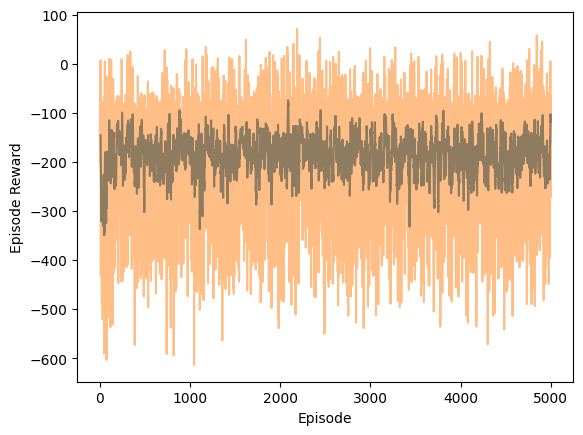

In [61]:
# plot stats
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0))
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, r, l = np.array(stats_reward_list).T
cum_r = get_running_stat(r, 10)
cum_l = get_running_stat(l, 10)

# plot rewards
plt.plot(episode[-len(cum_r):], cum_r)
plt.plot(episode, r, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')

Text(0, 0.5, 'Episode Length')

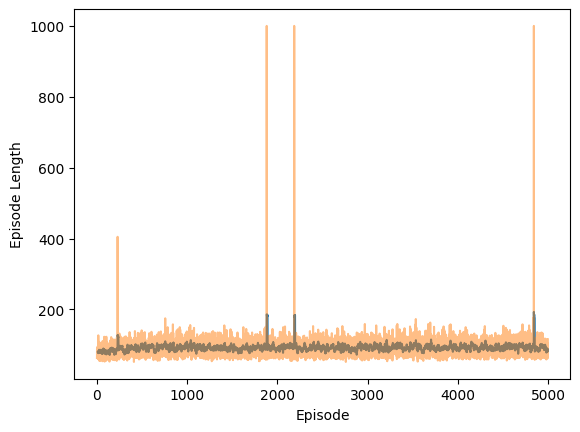

In [62]:
# plot episode lengths
plt.plot(episode[-len(cum_l):], cum_l)
plt.plot(episode, l, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Length')